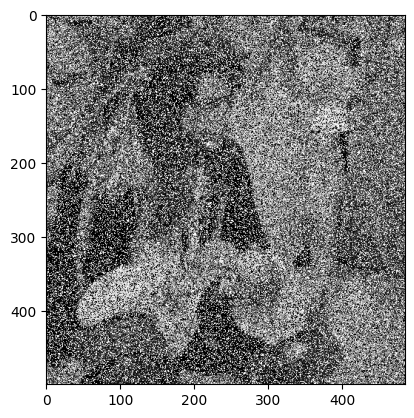

In [2]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)
m, n = image.shape  # 500, 485
num_rand = int(0.5 * m * n)

# salt-and-pepper noise
rand_generator = np.random.default_rng(seed=0)
all_indices = [i for i in range(m * n)]
random.shuffle(all_indices)
rand_indices = all_indices[: num_rand]  # indices to add noise
clean_indices = all_indices[num_rand: ]  # clean indices not add noise
image_noise = np.copy(image)
for i in rand_indices:
    image_noise.flat[i] = rand_generator.choice([0, 255])

plt.imshow(image, cmap='gray')
plt.imshow(image_noise, cmap='gray')
plt.show()

Singular: [62988.51, 3233.77, 3196.22, 3188.35, 3158.44, 3146.36, 3133.35, 3131.0, 3083.59, 3071.84]
Epoch 0, relative_error: 0.793, PSNR: 9.753
Singular: [59103.7, 3199.88, 2863.45, 2776.64, 2723.94, 2708.97, 2694.8, 2675.64, 2666.06, 2636.58]
Epoch 1, relative_error: 0.717, PSNR: 10.626
Singular: [56839.43, 4254.84, 3583.45, 3152.2, 3048.96, 2797.7, 2672.11, 2612.34, 2589.97, 2574.5]
Epoch 2, relative_error: 0.684, PSNR: 11.031
Singular: [55497.22, 5019.94, 4161.7, 3578.41, 3433.04, 3033.98, 2818.05, 2693.0, 2642.2, 2631.34]
Epoch 3, relative_error: 0.669, PSNR: 11.233
Singular: [54686.69, 5506.76, 4535.88, 3873.34, 3693.96, 3212.26, 2949.87, 2807.22, 2722.92, 2697.17]
Epoch 4, relative_error: 0.659, PSNR: 11.355
Singular: [54186.27, 5811.45, 4770.64, 4061.92, 3859.53, 3327.4, 3040.13, 2889.4, 2783.4, 2744.26]
Epoch 5, relative_error: 0.652, PSNR: 11.448
Singular: [53868.26, 6003.67, 4918.02, 4180.21, 3963.04, 3398.18, 3096.58, 2940.59, 2821.33, 2772.39]
Epoch 6, relative_error: 0.64

True

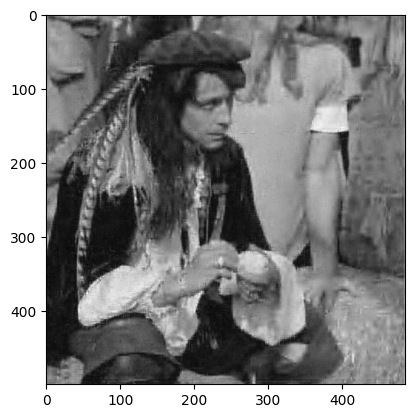

In [6]:
def POmega(matrix, clean_indices):
    """
    elements of 'clean_indices' kept unchanged, others set 0
    """
    a = np.zeros(matrix.shape)
    a.flat[clean_indices] = matrix.flat[clean_indices]
    return a

gamma1, gamma2 = 10000, 30000
def derivative(theta, gamma1=gamma1, gamma2=gamma2):
    """
    derivative of the penalty function
    """
    if theta <= gamma1:
        return 1
    elif theta <= gamma2:
        return (gamma2 - theta) / (gamma2 - gamma1)
    else:
        return 0

beta = 5
mu = 100
lamda = mu / beta
# X = np.copy(image_noise)
# X = np.zeros(image_noise.shape)
X = rand_generator.integers(0, 256, size=image_noise.shape)
# X.flat[clean_indices] = image_noise.flat[clean_indices]

RE, PSNR = [], []
for t in range(500):
    Ux, Sx, Vx = np.linalg.svd(X)  # (500, 500), (485,), (485, 485)
    S_output = [round(i, 2) for i in Sx[:10]]
    print(f"Singular: {S_output}")

    w = np.array([derivative(i) for i in Sx])
    Y = X - 2 * POmega(X - image_noise, clean_indices) / beta
    Uy, Sy, Vy = np.linalg.svd(Y)  # (500, 500), (485,), (485, 485)
    
    # check SVD
    # print((np.linalg.multi_dot([Uy, np.pad(np.diag(Sy), pad_width=((0, 500 - 485), (0, 0))), Vy]) - Y) <= 1e-3)
    
    S = np.diag(Sy - lamda * w)
    S[S < 0] = 0
    S = np.pad(S, pad_width=((0, 500 - 485), (0, 0)))
    X = np.linalg.multi_dot([Uy, S, Vy])

    relative_error = np.linalg.norm(X - image) / np.linalg.norm(image)
    psnr = 10 * np.log10(255 ** 2 / (np.linalg.norm(X - image) ** 2 / (m * n)))
    RE.append(relative_error)
    PSNR.append(psnr)
    print(f"Epoch {t}, relative_error: {relative_error:.3f}, PSNR: {psnr:.3f}")
    if relative_error <= 1e-3:
        break

plt.imshow(X, cmap='gray')
cv2.imwrite('image_recover-full_random_init.jpg', X)

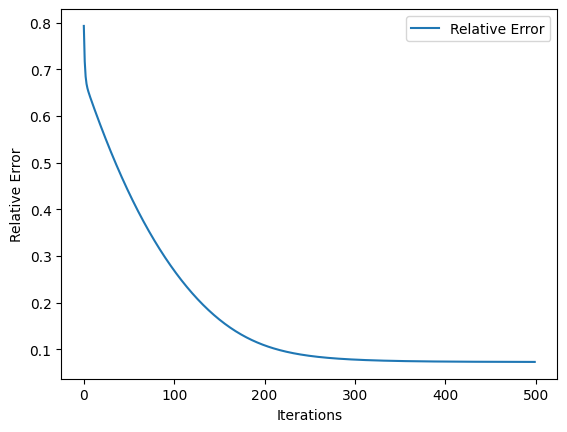

In [20]:
# plot
t = [i for i in range(500)]
plt.plot(t, RE, label='Relative Error')
plt.xlabel("Iterations")
plt.ylabel("Relative Error")
plt.legend()
plt.savefig('RE.pdf')
plt.show()

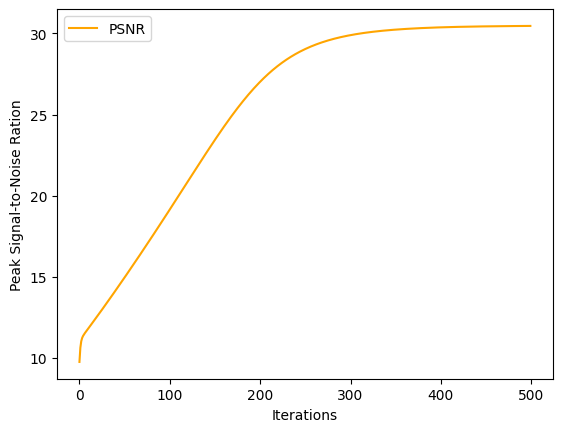

In [18]:
plt.plot(t, PSNR, label='PSNR', color='orange')
plt.xlabel("Iterations")
plt.ylabel("Peak Signal-to-Noise Ration")
plt.legend()
plt.savefig('PSNR.pdf')
plt.show()

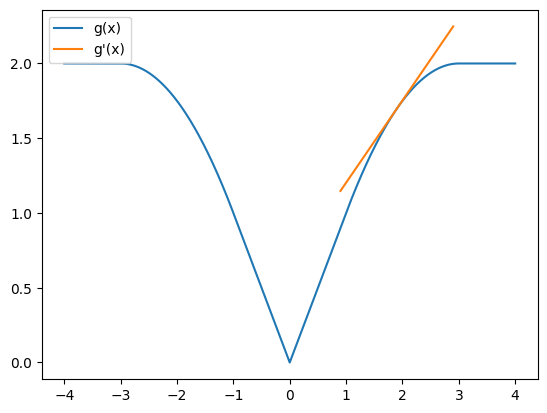

In [5]:
# dirivative, code check
gamma1, gamma2 = 1, 3
def derivative(theta, gamma1=gamma1, gamma2=gamma2):
    """
    derivative of the penalty function
    """
    if theta <= gamma1:
        return 1
    elif theta <= gamma2:
        return (gamma2 - theta) / (gamma2 - gamma1)
    else:
        return 0
def penalty_func(theta, gamma1=gamma1, gamma2=gamma2):
    """
    Penalty Function
    theta: scalar, input variable
    """
    if abs(theta) <= gamma1:
        return abs(theta)
    elif abs(theta) <= gamma2:
        return (2 * gamma2 * abs(theta) - theta * theta - gamma1 * gamma1) \
        / (2 * (gamma2 - gamma1))
    else:
        return (gamma1 + gamma2) / 2

x = np.linspace(-4, 4, 100000)
y = [penalty_func(i, gamma1, gamma2) for i in x]
plt.plot(x, y, label='g(x)')

input = 1.9
point = (input, penalty_func(input))
x_line = np.linspace(point[0] - 1, point[0] + 1, 10)
y_line = derivative(input) * (x_line - point[0]) + point[1]
plt.plot(x_line, y_line, label='g\'(x)')
plt.legend()
plt.show()